In [ ]:
!pip install opencage
!pip install folium

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencage.geocoder import OpenCageGeocode
import time
import folium
from folium.plugins import HeatMap, MarkerCluster, MiniMap, Fullscreen
import branca.colormap as cm
import os
from google.colab import files
from datetime import datetime

In [ ]:
file1 = '2023.csv'
file2 = '2024.csv'
file3 = '2025.csv'

In [ ]:
try:
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)
except FileNotFoundError:
    print(f"One or more CSV files not found.")
    exit()

In [ ]:
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df

,case_id,GV_team_member,attend_by,hospital_name,client_name,client_phone,services,call_outcome,call_outcome_details,hold_time_sec,call_start_time,call_end_time,call_time,call_date,is_submitted
0,25768539,Danielle Schunck,{6674},Pender Vet Animal Hospital - V.E.T.,Ryan Messick,1.703625e+10,{VSCR},emergency,"{""emergency"":""onTheWay"",""datetime"":""2023-01-01...",82.0,31-12-2022 23:56,01-01-2023 00:11,14.66,01-01-2023 00:00,True
1,25768540,Belinda Jones,{6666},Thompson Animal Medical Center,Dan Pizzi,1.630310e+10,"{""After hours on call""}",emergency,"{""emergency"":""referToPPH"",""accepted"":true}",47.0,31-12-2022 23:57,01-01-2023 00:04,6.85,01-01-2023 00:00,True
2,25768541,"Erika Vinson, CVT PA",{6098},Emergency Veterinary Services of Roanoke - CVT...,Houston Jessee,1.540526e+10,{VSCR},emergency,"{""emergency"":""onTheWay"",""datetime"":""2023-01-01...",40.0,31-12-2022 23:57,01-01-2023 00:04,7.19,01-01-2023 00:00,True
3,25768542,Michaela Diggs,{6504},DoveLewis Veterinary Emergency Hospital-VCSR -...,Hillary Gray,1.503850e+10,{VSCR},emergency,"{""emergency"":""referToEr"",""accepted"":true}",61.0,31-12-2022 23:59,01-01-2023 00:08,8.82,01-01-2023 00:00,True
4,25768543,Lindsey Greene,{6418},Metropolitan Veterinary Specialists and Emerge...,Denied Denied,1.502645e+10,"{VSCR,Overflow}",NaN,NaN,10.0,31-12-2022 23:59,01-01-2023 00:02,2.51,01-01-2023 00:02,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513960,26282499,"Katherine Wexler CVT/LVT (WI,NY)","{6119,6119,6119}",Mt. Pleasant Hospital for Animals,Tiana Cerrone,1.203417e+10,"{""After hours on call"",""After hours referral o...",administrative,"{""administrative"":""call"",""outcomes"":[""General ...",8.0,2025-03-11 09:54:36,2025-03-11 09:56:59,2.39,2025-03-11 09:56:04,True
513961,26282500,Courtney Hendrix LVT (NY),"{7191,7191,7191}",Boston Veterinary Clinic - SI,Kyle Ferber,1.617447e+10,"{""After hours referral only""}",administrative,"{""administrative"":""call"",""outcomes"":[""General ...",6.0,2025-03-11 09:55:22,2025-03-11 09:57:41,2.31,2025-03-11 09:57:14,True
513962,26282501,"Katherine Wexler CVT/LVT (WI,NY)","{6119,6119,6119,6119,6119}",DoveLewis Veterinary Emergency Specialty Hospital,Jennifer Emerson,1.971420e+10,"{Overflow,VSCR}",emergency,"{""emergency"":""referToEr"",""accepted"":true,""date...",8.0,2025-03-11 10:04:40,2025-03-11 10:06:32,1.87,2025-03-11 10:07:17,True
513963,26282502,"Katherine Wexler CVT/LVT (WI,NY)","{6119,6119,6119,6119,6119,6119,6119,6119,6119}",DoveLewis Veterinary Emergency Specialty Hospital,Ethan Swinford,1.502330e+10,"{Overflow,VSCR}",emergency,"{""emergency"":""referToEr"",""accepted"":true,""date...",11.0,2025-03-11 10:22:22,2025-03-11 10:25:24,3.04,2025-03-11 10:24:41,True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
columns_to_remove = ['case_id', 'attend_by', 'client_phone', 'call_time', 'is_submitted']
combined_df = combined_df.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
combined_df = combined_df.dropna()

In [ ]:
hold_hospital_df = combined_df[['hold_time_sec', 'hospital_name']].copy()
hold_outcome_df = combined_df[['hold_time_sec', 'call_outcome']].copy()
hold_services_df = combined_df[['hold_time_sec', 'services']].copy()
hold_call_times_df = combined_df[['hold_time_sec', 'call_start_time', 'call_end_time']].copy()
hold_call_date_df = combined_df[['hold_time_sec', 'call_date']].copy()

In [ ]:
unique_hospitals = hold_hospital_df['hospital_name'].dropna().unique()
print(f"Number of unique hospitals: {len(unique_hospitals)}")
unique_hospitals[:10]

Number of unique hospitals: 486


array(['Pender Vet Animal Hospital - V.E.T.',
       'Thompson Animal Medical Center ',
       'Emergency Veterinary Services of Roanoke - CVT only',
       'DoveLewis Veterinary Emergency Hospital-VCSR - CVT ONLY',
       'Black River Valley Veterinary Clinic - NY (DBA Valley Veterinary)',
       'Cowlitz Animal Clinic', 'Best Friends Animal Hospital',
       'Flossmoor Animal Hospital',
       'Animal Care Center MN......Shared On-Call available',
       'Island Animal Hospital '], dtype=object)

In [ ]:
coord_file = "hospital_locations_cache.csv"

if os.path.exists(coord_file):
    print("📍 Loading cached coordinates from CSV...")
    hospital_location_df = pd.read_csv(coord_file)
else:
    print("🌍 No cache found, making API calls to geocode hospitals...")

    key = 'c6a1ffc422894dd7ab491f0afb7f9634'
    geocoder = OpenCageGeocode(key)

    hospital_locations = []

    for hospital in unique_hospitals:
        try:
            query = hospital + ", USA"
            result = geocoder.geocode(query)
            if result and len(result):
                lat = result[0]['geometry']['lat']
                lng = result[0]['geometry']['lng']
                hospital_locations.append({
                    'hospital_name': hospital,
                    'latitude': lat,
                    'longitude': lng
                })
            else:
                print(f"⚠️ No results for: {hospital}")
        except Exception as e:
            print(f"❌ Error with hospital '{hospital}': {e}")
        time.sleep(1)

    hospital_location_df = pd.DataFrame(hospital_locations)

    # Save to cache
    hospital_location_df.to_csv(coord_file, index=False)
    print("✅ Saved coordinates to hospital_locations_cache.csv")

📍 Loading cached coordinates from CSV...


In [ ]:
# Group by hospital and calculate average hold time
avg_hold_df = hold_hospital_df.groupby('hospital_name', as_index=False)['hold_time_sec'].mean()
avg_hold_df.rename(columns={'hold_time_sec': 'avg_hold_time_sec'}, inplace=True)

# Merge with the hospital locations
hospital_map_data = pd.merge(avg_hold_df, hospital_location_df, on='hospital_name', how='inner')
hospital_map_data.head()

,hospital_name,avg_hold_time_sec,latitude,longitude
0,ANSWER ASAP Premium Vet Care - VCSR,7.500000e+00,42.267786,-94.271919
1,Acton Animal Hospital,8.267983e+06,42.479894,-71.445776
2,Ada Animal Hospital,1.663478e+02,42.955080,-85.486109
3,Adams Pet Hospital,4.209210e+06,42.112607,-85.527352
4,Advanced Animal Health Center,2.027805e+06,38.236789,-78.388416


In [ ]:
# Create base map centered around average hospital location
map_center = [hospital_map_data['latitude'].mean(), hospital_map_data['longitude'].mean()]
heatmap_map = folium.Map(location=map_center, zoom_start=10)

# Prepare data for HeatMap: [latitude, longitude, avg_hold_time_sec]
heat_data = [
    [row['latitude'], row['longitude'], row['avg_hold_time_sec']]
    for index, row in hospital_map_data.iterrows()
]

# Add heat map layer
HeatMap(heat_data, radius=15).add_to(heatmap_map)

# Show map
heatmap_map

In [ ]:
# Step 1: Center of the map
map_center = [hospital_map_data['latitude'].mean(), hospital_map_data['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Step 2: Create heatmap data using average hold time as weight
heat_data = [
    [row['latitude'], row['longitude'], row['avg_hold_time_sec']]
    for _, row in hospital_map_data.iterrows()
]

# Step 3: Get min and max hold time for scaling
min_hold = hospital_map_data['avg_hold_time_sec'].min()
max_hold = hospital_map_data['avg_hold_time_sec'].max()

# Step 4: Add heatmap layer
HeatMap(
    data=heat_data,
    radius=25,
    blur=15,
    max_zoom=1,
    min_opacity=0.4,
    max_val=max_hold
).add_to(m)

# Step 5: Add color scale for circle markers
colormap = cm.LinearColormap(colors=['green', 'orange', 'red'], vmin=min_hold, vmax=max_hold)

# Step 6: Add circle markers with popups
for _, row in hospital_map_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=7,
        popup=folium.Popup(f"<b>{row['hospital_name']}</b><br>Avg Hold Time: {row['avg_hold_time_sec']:.1f} sec", max_width=250),
        color=colormap(row['avg_hold_time_sec']),
        fill=True,
        fill_color=colormap(row['avg_hold_time_sec']),
        fill_opacity=0.8
    ).add_to(m)

# Step 7: Add color legend
colormap.caption = 'Average Hold Time (seconds)'
colormap.add_to(m)

# Step 8: Add mini map and fullscreen control
m.add_child(MiniMap(toggle_display=True))
m.add_child(Fullscreen())

# Display map
m

<ipython-input-30-3016a7987712>:16: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


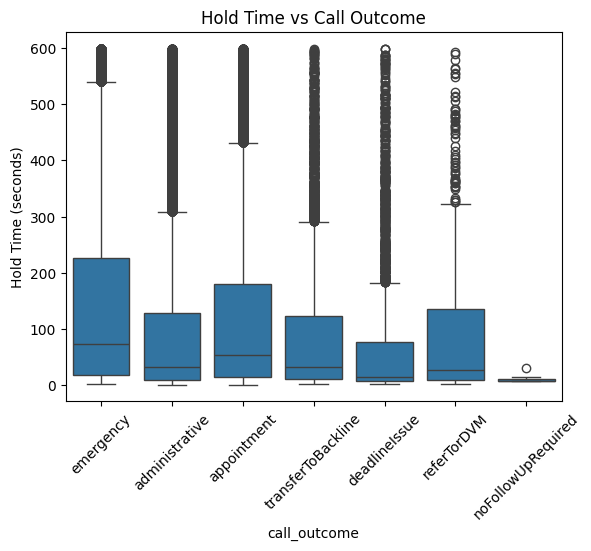

In [ ]:
# Filter valid range: keep between 1 sec and 600 sec
filtered_df = hold_outcome_df[(hold_outcome_df['hold_time_sec'] > 0) & (hold_outcome_df['hold_time_sec'] < 600)]

sns.boxplot(x='call_outcome', y='hold_time_sec', data=filtered_df)
plt.xticks(rotation=45)
plt.title("Hold Time vs Call Outcome")
plt.ylabel("Hold Time (seconds)")
plt.show()

<ipython-input-54-17f9096ca28a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_services_df['services'] = filtered_services_df['services'].astype(str)
<ipython-input-54-17f9096ca28a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_services_df['services'] = filtered_services_df['services'].str.replace(r"[{}']", "", regex=True)
<ipython-input-54-17f9096ca28a>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variabl

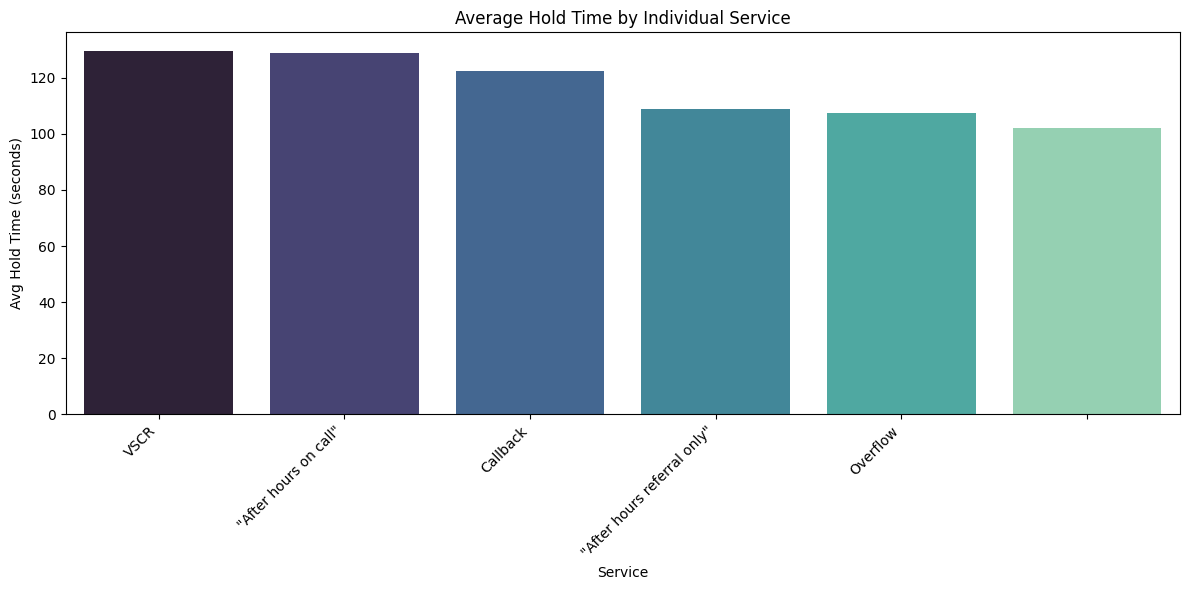

In [ ]:
# Remove outliers first
filtered_services_df = hold_services_df[
    (hold_services_df['hold_time_sec'] > 0) &
    (hold_services_df['hold_time_sec'] < 600)
]

# Convert services column to strings
filtered_services_df['services'] = filtered_services_df['services'].astype(str)

# Split on commas or semicolons or inside sets
filtered_services_df['services'] = filtered_services_df['services'].str.replace(r"[{}']", "", regex=True)
filtered_services_df = filtered_services_df.assign(service_individual=filtered_services_df['services'].str.split(','))

# Explode into multiple rows (1 per service)
exploded_df = filtered_services_df.explode('service_individual')
exploded_df['service_individual'] = exploded_df['service_individual'].str.strip()

# Group by individual service
avg_hold_by_service = exploded_df.groupby('service_individual')['hold_time_sec'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_hold_by_service.index, y=avg_hold_by_service.values, palette="mako")
plt.xticks(rotation=45, ha='right')
plt.title("Average Hold Time by Individual Service")
plt.ylabel("Avg Hold Time (seconds)")
plt.xlabel("Service")
plt.tight_layout()
plt.show()

<ipython-input-73-9a6228a0951c>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_call_by_hold_bin = filtered_duration_df.groupby('hold_time_bin')['call_duration_sec'].mean()


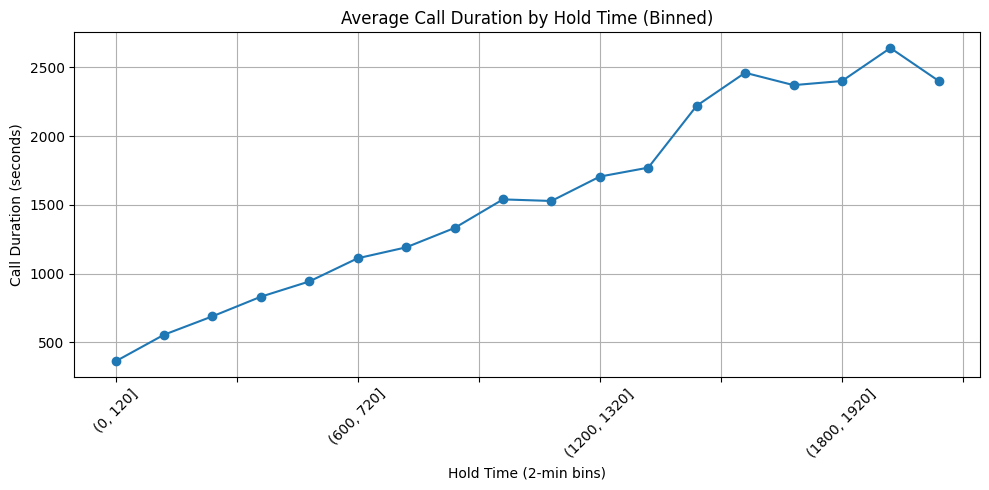

In [ ]:
# Convert strings to datetime
hold_call_times_df['call_start_time'] = pd.to_datetime(hold_call_times_df['call_start_time'], errors='coerce', format='mixed')
hold_call_times_df['call_end_time'] = pd.to_datetime(hold_call_times_df['call_end_time'], errors='coerce', format='mixed')

# Calculate duration in seconds
hold_call_times_df['call_duration_sec'] = (
    hold_call_times_df['call_end_time'] - hold_call_times_df['call_start_time']
).dt.total_seconds()

# Bin hold times instead of call durations (e.g., every 2 mins up to 1 hour)
filtered_duration_df['hold_time_bin'] = pd.cut(
    filtered_duration_df['hold_time_sec'],
    bins=range(0, 3601, 120)  # 2-minute bins
)

# Average call duration per hold time bin
avg_call_by_hold_bin = filtered_duration_df.groupby('hold_time_bin')['call_duration_sec'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_call_by_hold_bin.plot(kind='line', marker='o')
plt.title("Average Call Duration by Hold Time (Binned)")
plt.xlabel("Hold Time (2-min bins)")
plt.ylabel("Call Duration (seconds)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

quarter
2023Q1    55498
2023Q2    60291
2023Q3    61016
2023Q4    55325
2024Q1    48567
2024Q2    45781
2024Q3    44047
2024Q4    37455
2025Q1    34858
Name: count, dtype: int64


<ipython-input-84-3f7d70b57ab2>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


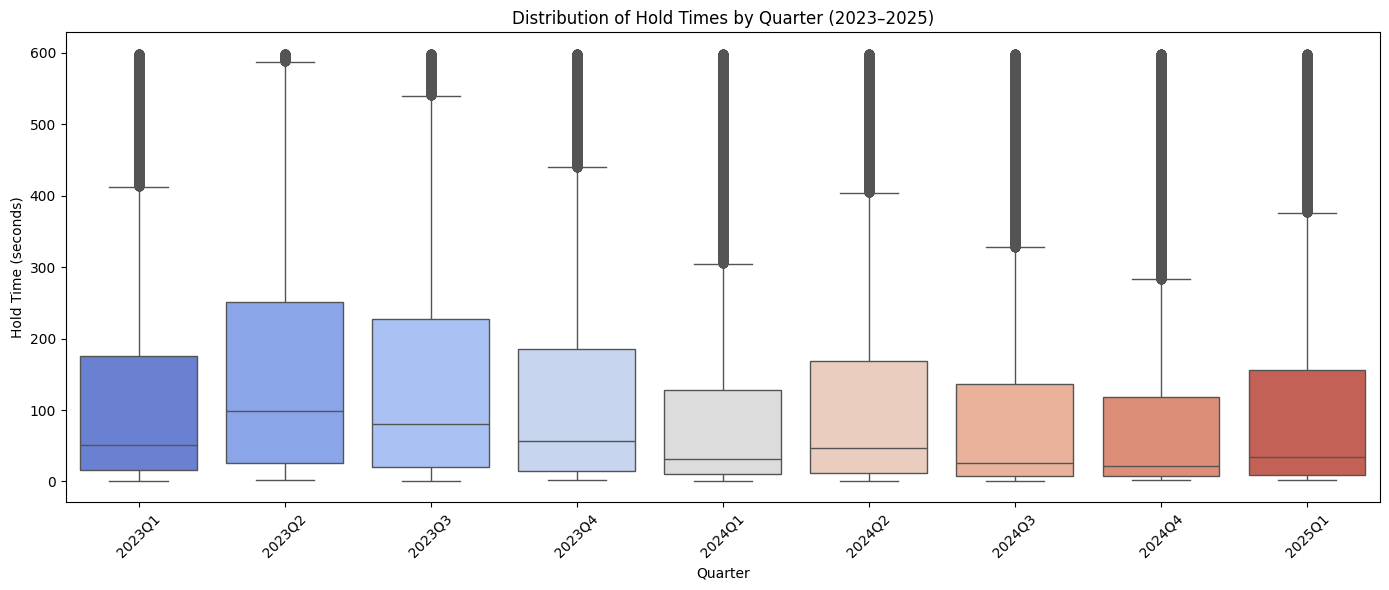

In [ ]:
# Step 1: Copy the full combined DataFrame
filtered_date_df = combined_df.copy()

# Step 2: Parse call_date using mixed format
filtered_date_df['call_date'] = pd.to_datetime(
    filtered_date_df['call_date'],
    errors='coerce',
    format='mixed'
)

# Step 3: Drop invalid dates and invalid hold times
filtered_date_df = filtered_date_df[
    (filtered_date_df['call_date'].notnull()) &
    (filtered_date_df['hold_time_sec'] > 0) &
    (filtered_date_df['hold_time_sec'] < 600)
].copy()

# Step 4: Create quarter column
filtered_date_df['quarter'] = filtered_date_df['call_date'].dt.to_period('Q').astype(str)

# Step 5: Define full quarter range from 2023 to 2025
all_quarters = pd.period_range(start='2023Q1', end='2025Q1', freq='Q').astype(str)

# Step 6: Force correct quarter ordering even if some are missing
filtered_date_df['quarter'] = pd.Categorical(
    filtered_date_df['quarter'],
    categories=all_quarters,
    ordered=True
)

# Step 7: Check quarter counts (optional debug)
print(filtered_date_df['quarter'].value_counts().sort_index())

# Step 8: Plot the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='quarter',
    y='hold_time_sec',
    data=filtered_date_df,
    palette='coolwarm'
)
plt.title("Distribution of Hold Times by Quarter (2023–2025)")
plt.xlabel("Quarter")
plt.ylabel("Hold Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-85-070a34f82e47>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="crest")


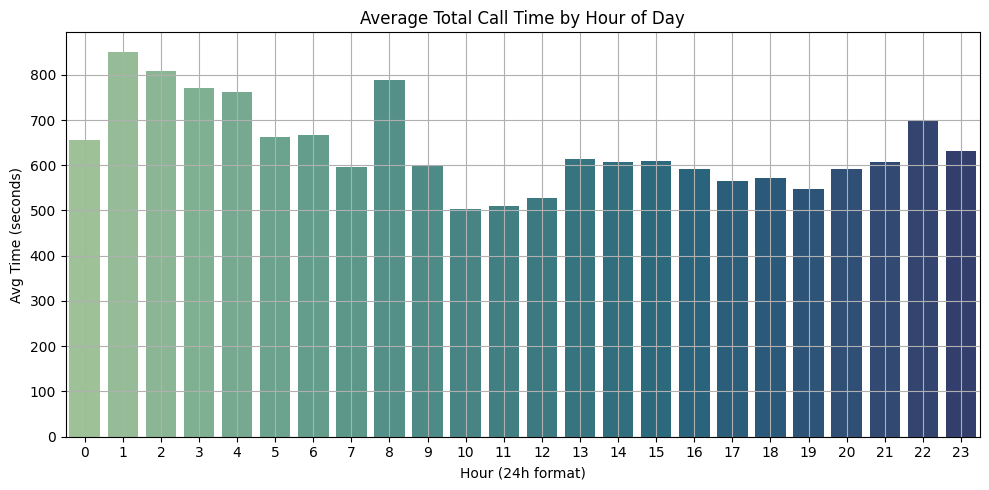

In [ ]:
hold_call_times_df['call_start_time'] = pd.to_datetime(
    hold_call_times_df['call_start_time'],
    errors='coerce',
    format='mixed'
)

# Step 1: Filter valid hold + duration values
filtered_duration_df = hold_call_times_df[
    (hold_call_times_df['hold_time_sec'] > 0) &
    (hold_call_times_df['hold_time_sec'] < 3600) &
    (hold_call_times_df['call_duration_sec'] > 0) &
    (hold_call_times_df['call_duration_sec'] < 3600) &
    (hold_call_times_df['call_start_time'].notnull())
].copy()

# Step 2: Compute total interaction time
filtered_duration_df['total_time_sec'] = (
    filtered_duration_df['hold_time_sec'] + filtered_duration_df['call_duration_sec']
)

# Step 3: Extract hour of day from start time
filtered_duration_df['hour'] = filtered_duration_df['call_start_time'].dt.hour

# Step 4: Group by hour and calculate average
hourly_avg = filtered_duration_df.groupby('hour')['total_time_sec'].mean()

# Step 5: Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="crest")
plt.title("Average Total Call Time by Hour of Day")
plt.xlabel("Hour (24h format)")
plt.ylabel("Avg Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-86-0bf8868e6bc0>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_avg.index, y=weekly_avg.values, palette="flare")


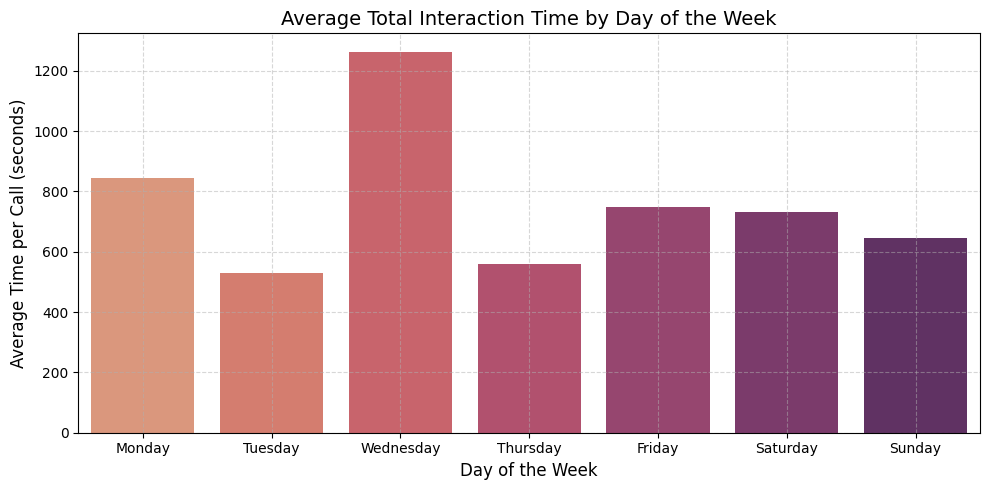

In [ ]:
# Step 0: Ensure call_start_time is in datetime format
hold_call_times_df['call_start_time'] = pd.to_datetime(
    hold_call_times_df['call_start_time'],
    errors='coerce',
    format='mixed'
)

# Step 1: Filter valid rows and compute total time
filtered_duration_df = hold_call_times_df[
    (hold_call_times_df['hold_time_sec'] > 0) &
    (hold_call_times_df['hold_time_sec'] < 3600) &
    (hold_call_times_df['call_duration_sec'] > 0) &
    (hold_call_times_df['call_duration_sec'] < 3600) &
    (hold_call_times_df['call_start_time'].notnull())
].copy()

filtered_duration_df['total_time_sec'] = (
    filtered_duration_df['hold_time_sec'] + filtered_duration_df['call_duration_sec']
)

# Step 2: Extract weekday and define order
filtered_duration_df['weekday'] = filtered_duration_df['call_start_time'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Step 3: Group and calculate average total time per weekday
weekly_avg = filtered_duration_df.groupby('weekday')['total_time_sec'].mean().reindex(weekday_order)

# Step 4: Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_avg.index, y=weekly_avg.values, palette="flare")
plt.title("Average Total Interaction Time by Day of the Week", fontsize=14)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Time per Call (seconds)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

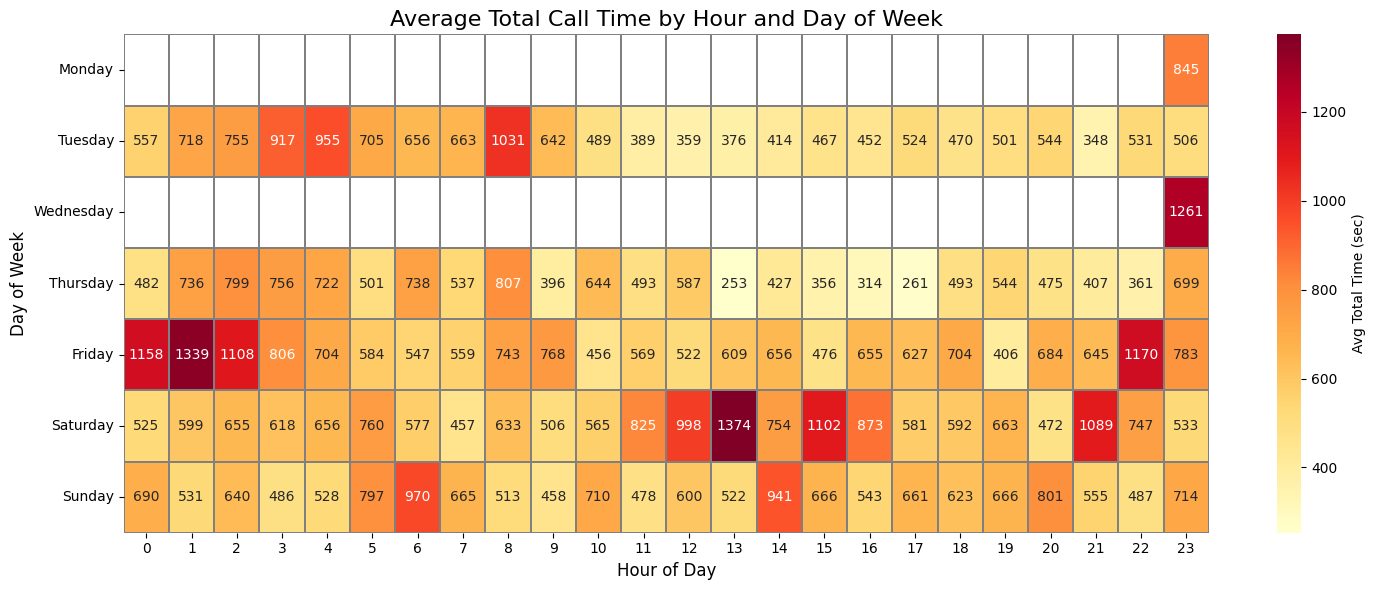

In [ ]:
# Step 1: Copy filtered DataFrame
df = filtered_duration_df.copy()

# Parse mixed-format datetime (only needed once at the beginning)
df['call_start_time'] = pd.to_datetime(
    df['call_start_time'],
    errors='coerce',
    format='mixed'
)

# Step 2: Extract hour and weekday
df['hour'] = df['call_start_time'].dt.hour
df['weekday'] = df['call_start_time'].dt.day_name()

# Step 3: Define weekday order (Monday–Sunday)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Step 4: Create pivot table with average total time per (weekday, hour)
heatmap_data = df.pivot_table(
    index='weekday',
    columns='hour',
    values='total_time_sec',
    aggfunc='mean'
).reindex(weekday_order)  # Ensure correct row order

# Step 5: Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    linewidths=0.3,
    linecolor='gray',
    annot=True,
    fmt=".0f",
    cbar_kws={'label': 'Avg Total Time (sec)'}
)

# Step 6: Final plot styling
plt.title("Average Total Call Time by Hour and Day of Week", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()